In [1]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import logomaker

# Insert path to mavenn beginning of path
import os
import sys
abs_path_to_mavenn = os.path.abspath('../../')
sys.path.insert(0, abs_path_to_mavenn)

# Load mavenn
import mavenn
print(mavenn.__path__)

['/Users/jkinney/github/mavenn/mavenn']


In [2]:
noise_model = 'SkewedT'
file_name = f'mpsa_{noise_model}'
train_model = False

# Load full MPSA dataset
data_df = mavenn.load_example_dataset(name='mpsa')

# Split into training and test data
ix = data_df['training_set']
training_df = data_df[ix].copy()
print(f'training N: {len(training_df)}')

# Split into training and test data
ix = data_df['training_set']
test_df = data_df[~ix].copy()
print(f'test N: {len(test_df)}')

if train_model:
    
    # Set seeed
    mavenn.set_seed(0)

    # Define model
    model = mavenn.Model(regression_type='GE',
                         L=len(data_df['x'][0]),
                         alphabet='dna',
                         gpmap_type='pairwise',                     
                         ge_noise_model_type=noise_model,
                         ge_heteroskedasticity_order=2)

    # Set training data
    model.set_data(x=data_df['x'],
                   y=data_df['y'])

    # Fit model to data
    history = model.fit(learning_rate=.005,
                        epochs=1000,
                        batch_size=250,
                        early_stopping=True,
                        early_stopping_patience=30)

    # Save model
    model.save(file_name)

training N: 17498
test N: 4431


In [3]:
model = mavenn.load(file_name)

Model loaded from these files:
	mpsa_SkewedT.pickle
	mpsa_SkewedT.h5


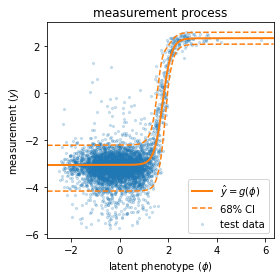

In [4]:
# Get x and y
x_test = test_df['x'].values
y_test = test_df['y'].values

# Predict latent phentoype values (phi) on test data
phi_test = model.x_to_phi(x_test)

# Predict measurement values (yhat) on test data
yhat_test = model.x_to_yhat(x_test)

# Set phi lims and create grid in phi space
phi_lim = [min(phi_test)-.5, max(phi_test)+.5]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Compute yhat each phi gridpoint
yhat_grid = model.phi_to_yhat(phi_grid)

# Compute 90% CI for each yhat
q = [0.05, 0.95] #[0.16, 0.84]
yqs_grid = model.yhat_to_yq(yhat_grid, q=q)

# Create figure
fig, ax = plt.subplots(1, 1, figsize=[4, 4])

# Illustrate measurement process with GE curve
ax.scatter(phi_test, y_test, color='C0', s=5, alpha=.2, label='test data')
ax.plot(phi_grid, yhat_grid, linewidth=2, color='C1',
        label='$\hat{y} = g(\phi)$')
ax.plot(phi_grid, yqs_grid[:, 0], linestyle='--', color='C1', label='68% CI')
ax.plot(phi_grid, yqs_grid[:, 1], linestyle='--', color='C1')
ax.set_xlim(phi_lim)
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_ylabel('measurement ($y$)')
ax.set_title('measurement process')
ax.legend()

# Fix up plot
fig.tight_layout()
plt.show()

In [5]:
N = len(test_df)
data_df = model.simulate_dataset(N)
print(f'simulation N: {N}')
data_df.head()

simulation N: 4431


,training_set,yhat,phi,y,x
0,True,-3.053159,-0.721900,-2.812080,CCAGCGCTT
1,False,-2.565130,1.360425,-2.811988,AGTGTAATT
2,True,-3.051724,-0.013834,-2.496668,CGCGCGATA
3,True,1.017953,1.972515,0.776733,ACGGTAGAT
4,True,-3.053643,-1.026524,-3.778166,ATTGCCCAA


(-8.460162162780762, 3.6995298862457275)

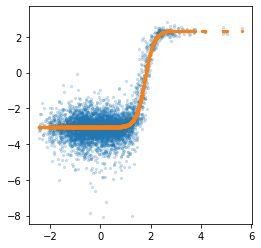

In [6]:
# Plot simulated data
fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.scatter(data_df['phi'], data_df['y'], color='C0', s=5, alpha=.2)
ax.scatter(data_df['phi'], data_df['yhat'], color='C1', s=5, alpha=1)
yhat = data_df['yhat'].values
delta_yhat = yhat.max() - yhat.min()
ylim = [yhat.min() - delta_yhat, yhat.max() + .25*delta_yhat]
ax.set_ylim(ylim)

In [7]:
model.simulate_dataset?